## Wczytaj potrzebne biblioteki

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import signal
%matplotlib inline

from sklearn import linear_model
from sklearn.metrics import r2_score
from scipy.optimize import differential_evolution
from sklearn import preprocessing

print("pandas version: {}".format(pd.__version__))
print("numpy version: {}".format(np.__version__))
print("matplotlib version: {}".format(mpl.__version__))

pandas version: 1.0.3
numpy version: 1.18.4
matplotlib version: 3.2.0


## Wczytaj dane

In [2]:
def changeDateToSeconds(df):
    first = df["date"][0]
    df["date"] = df["date"].apply(lambda timestamp: (timestamp-first).seconds)
    return df

def readDataFromExcel(path, sheet):
    df = pd.read_excel(path, sheet_name=sheet, na_values=[" Bad Data","Bad Data"])
    df["date"] = pd.to_datetime(df["date"])
    df = changeDateToSeconds(df)
    return df

df2 = readDataFromExcel("./data/K-1_MI.xlsx", "d2")
df3 = readDataFromExcel("./data/K-1_MI.xlsx", "d3")
df5 = readDataFromExcel("./data/K-1_MI.xlsx", "d5")
df6 = readDataFromExcel("./data/K-1_MI.xlsx", "d6")

df6 = df6.iloc[::5, :] # dopasuj okresy próbkowania

dataFrames = [df2, df3, df5, df6]

## Skalowanie i oczyszczanie danych

In [3]:
scaledDf = df2.append(df3).append(df5).append(df6)
scaler = preprocessing.StandardScaler()
scaledDf = scaledDf.drop(["date"], axis=1)
columns = scaledDf.columns

scaler.fit(scaledDf)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [4]:
scaledDataFrames = list()
for df in dataFrames:
    df = scaler.transform(df.drop(["date"], axis=1))
    scaledDataFrames.append(pd.DataFrame(df, columns=columns))

### Tworzenie macierzy regresji

In [5]:
def prepareSignals(df, inputs, output, medfilt=False, kernelSize=11):
    inputSignals = df[inputs]
    outputSignal = df[output]
    inputFrame = pd.concat([inputSignals, outputSignal.shift(1)], axis=1).iloc[1:]

    if(medfilt == True):
        u_signals = applyMedianFilter(inputFrame.to_numpy(), kernelSize)
        y_signal = applyMedianFilter(df[output].iloc[1:].to_numpy(), kernelSize)

    else:
        u_signals = inputFrame.to_numpy()
        y_signal =  df[output].iloc[1:].to_numpy()
        
    return (u_signals, y_signal)

In [6]:
def createModelMatrixForSingleInput(data, order, delay, exponent):
    if(order < 0 or delay < 0 or exponent <= 0):
        raise AssertionError("Invalid structure parameter")
        
    samples = data.shape[0]
    widthCoefficient = (order + 1)*exponent
    heightAbsoluteTerm = order + delay
    
    A = np.zeros([samples - heightAbsoluteTerm, widthCoefficient])
    
    for j in range(order+1):
        for k in range(exponent):
            colIndex = (order-j)*exponent + k
            A[:, colIndex] = np.power(data[j : samples-heightAbsoluteTerm+j], k+1)
    
    return A

In [7]:
def findMaxDelayAndOrder(M):
    maxDelay = 0; maxOrder = 0
    for index, parameters in enumerate(M.T):
        order, delay, exponent = parameters
        if(order > maxOrder):
            maxOrder = order
        if(delay > maxDelay):
            maxDelay = delay
    
    return maxDelay, maxOrder

In [8]:
def createModelMatrix(data, M):
    if(M.shape[0] != 3):
        raise AssertionError("Invalid parameter vector size")

    if(M.shape[1] != data.shape[1]):
        raise AssertionError("Mismatched size of data: {} and M: {} vector".format(data.shape, M.shape))
        
    inputs = M.shape[1]
    height = data.shape[0]
    
    maxDelay, maxOrder = findMaxDelayAndOrder(M)
    A = np.empty(shape=(height-maxOrder-maxDelay, 0)) 
    for index, parameters in enumerate(M.T):
        # stworz macierz dla danego wejscia
        inputData = data[:, index]
        order, delay, exponent = parameters
        Ap = createModelMatrixForSingleInput(data[:, index], order, delay, exponent)
        
        # obetnij macierz - delay od góry, a order od dołu macierzy
        delayMaxDiff = np.abs(maxDelay-delay)
        orderMaxDiff = np.abs(maxOrder-order)
        baseHeight = Ap.shape[0]
        validA = Ap[orderMaxDiff+delayMaxDiff:]
        validA = validA[:A.shape[0]]
        
        # dodaj do akumulatora
        A = np.concatenate((A, validA), axis=1)
        
    return A

## Oblicz wynik modelu

In [9]:
def evalModelScore(model, M, u_verif, y_verif):
    maxDelay, maxOrder = findMaxDelayAndOrder(M)   
    numberOfSamples = y_verif.shape[0]
    output_verif_cut = y_verif[maxDelay : numberOfSamples - maxOrder]
    
    data_idx = maxOrder+maxDelay+1
    u_verif_wip = np.array(u_verif[0:data_idx],copy=True)
    A_verif = createModelMatrix(u_verif_wip, M)
    
    model_outputs = np.array([])
    for i in range(data_idx, data_idx+len(output_verif_cut)):
        output_model_verif = model.predict(A_verif)
        model_outputs = np.append(model_outputs, output_model_verif)
        u_verif_wip = np.vstack((u_verif_wip, u_verif[data_idx:data_idx+1]))[1:]
        data_idx += 1
        u_verif_wip[-1][-1] = output_model_verif[-1]
        A_verif = createModelMatrix(u_verif_wip, M) 
        
    verif_score = r2_score(output_verif_cut, model_outputs)
    return verif_score

In [10]:
def crossValidate(M, dataFrames, inputs, outputs):
    maxDelay, maxOrder = findMaxDelayAndOrder(M)
    regressors = inputs + outputs
    scores = list()
    for df_verif in dataFrames:
        u_verif, y_verif = prepareSignals(df_verif, inputs, outputs)
        A_learn = None
        y_learn = None
        for df_learn in dataFrames:
            if df_verif.equals(df_learn):
                continue
            
            u, y = prepareSignals(df_learn, inputs, outputs)
            A = createModelMatrix(u, M)
            
            if A_learn is None:
                A_learn = np.empty((0, A.shape[1]))
            if y_learn is None:
                y_learn = np.empty((0, y.shape[1]))
            
            numberOfSamples = y.shape[0]
            y_cut = y[maxDelay : numberOfSamples - maxOrder]
            A_learn = np.vstack((A_learn, A))
            y_learn = np.vstack((y_learn, y_cut))
        
        
        model = linear_model.LinearRegression().fit(A_learn, y_learn)
        score = evalModelScore(model, M, u_verif, y_verif)
        scores.append(score)
    
    return sum(scores)/len(scores)

## Ręczne szukanie struktury modelu

In [49]:
inputs = ["FWF", "PP"]
output = ["LT01"]

M = np.array([[1,20,1],[1,20,1],[1,1,1]]).transpose()
score = crossValidate(M, scaledDataFrames, inputs, output)
print(score)

AssertionError: Mismatched size of data: (998, 46) and M: (3, 3) vector

## Uruchom algorytm genetyczny do znalezienia struktury modelu

In [50]:
inputs = ['FP05', 'LT1', 'TMB', 'TMC', 'TMD', 'TME', 'TMF', 'PWB', 'PWC', 'PWD',
       'PWE', 'PP', 'PW1', 'PW2', 'O2A', 'O2B', 'WP1', 'WDP', 'TP1', 'TP2',
       'DP', 'TS1', 'TS2', 'FWF', 'ZS1', 'ZS2', 'PT05', 'PT01', 'TS01',
       'TS03', 'TS02', 'FW01', 'TS05', 'TS04', 'FW02', 'TTWS', 'PTWS', 'TW02',
       'TW01', 'FW03', 'TW04', 'TW03', 'FW04', 'PTWT', 'PPW']
output = ["LT01"]

cache = {}

def goalFunction(x):
    # zbuduj macierz M na podstawie wektora x
    M = np.empty(shape=(3, len(inputs) + 1), dtype=np.int32)
    for index, value in enumerate(x):
        row = index % 3; col = index // 3
        M[row, col] = int(value)
        
    M_hash = hash(str(M))
    if M_hash in cache:
        score = cache[M_hash]
    else:
        score = crossValidate(M, scaledDataFrames, inputs, output)
        cache[M_hash] = score
        
    return (-1)*score

In [51]:
bounds = [(0, 5), (0,30), (1, 2)]*(len(inputs) + 1)
bounds[-2] = (0,0)
result = differential_evolution(goalFunction, bounds, disp=True, polish=False, tol=10.0, updating="deferred", workers=4)

differential_evolution step 1: f(x)= 0.102006


In [52]:
result

     fun: 0.10200573538443738
 message: 'Optimization terminated successfully.'
    nfev: 4140
     nit: 1
 success: True
       x: array([ 1.7701155 , 20.42044817,  1.0696059 ,  4.24664564,  4.92101608,
        1.97355617,  2.86239253, 16.1645101 ,  1.66333762,  3.42945442,
       20.67018491,  1.95952461,  0.49735925, 24.66395883,  1.09881886,
        1.87718693,  6.8901269 ,  1.74799679,  2.35497816, 16.70582063,
        1.14604248,  1.78811223,  4.45881446,  1.09081917,  4.80668833,
        2.96673985,  1.68287176,  4.18526576, 27.14567904,  1.13750605,
        0.50108797,  1.28975182,  1.48211115,  4.76563616,  2.93546243,
        1.5680497 ,  0.9815658 , 20.50288737,  1.16098592,  4.84797307,
        8.07287821,  1.22344099,  1.70040561,  7.06472365,  1.55614365,
        1.91892749,  7.53175512,  1.87336521,  2.19237624,  9.22362428,
        1.43968363,  4.61703101,  3.00241619,  1.02480086,  3.84844481,
        2.98543174,  1.98854448,  4.15810407,  7.49942245,  1.16316851,
    

[[ 1  4  2  3  0  1  2  1  4  4  0  4  0  4  1  1  2  4  3  4  1  0  1  4
   0  2  0  4  2  4  4  1  4  2  4  0  0  4  1  0  3  1  3  1  3  1]
 [20  4 16 20 24  6 16  4  2 27  1  2 20  8  7  7  9  3  2  7 20 26  1  4
  10 23 12 17 20  8  8 28 13  5  2 16 20  1 25 22 10 17 15 28  4  0]
 [ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]]
(2898, 141)
[[-8.39352205e-02 -6.11185768e-01  2.61832467e-01  2.33638110e-01
  -3.18031680e-01 -2.50134935e-01  8.85908587e-02 -8.08706298e-01
   9.26885681e-01  7.53534228e-01 -3.10558034e-01 -5.27239936e-01
  -6.89462760e-02  7.37228834e-01 -1.17845700e+00 -4.84409074e-01
   5.99006318e-01 -2.18293678e+00  2.08237573e+00  7.97390934e-01
   3.05477799e-01 -7.76187291e-02  1.16343290e-01 -1.67064749e-01
  -4.92969052e-02 -5.36780149e-03  1.48692877e-01 -1.16978210e-01
  -4.83485650e-02 -2.61983771e-02  1.32457897e-01  1.86976651e-02
  -3.47628824e-01 -7.34502514e

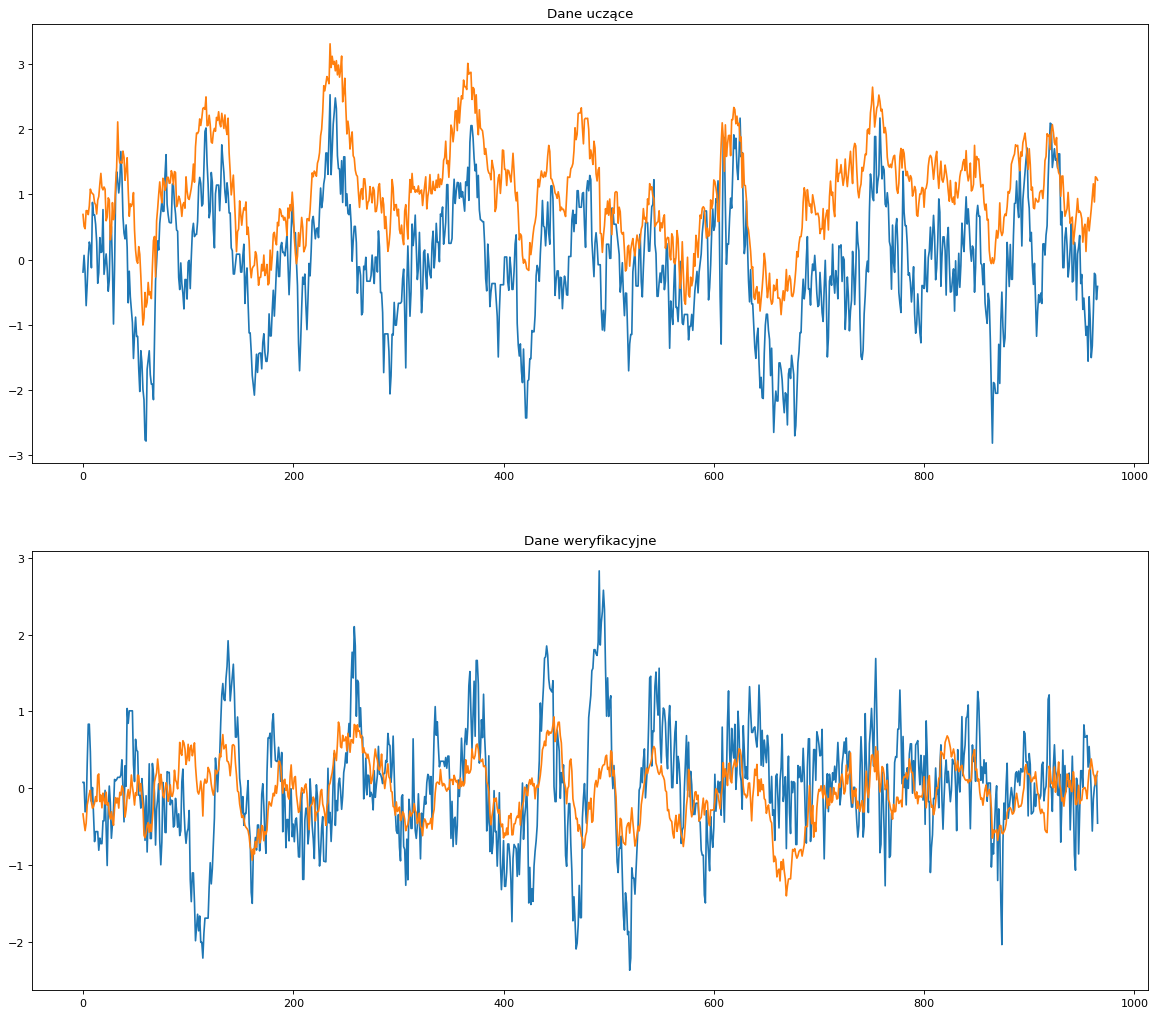

In [56]:
optimM = np.empty(shape=(3, len(inputs) + 1), dtype=np.int32)
for index, value in enumerate(result.x):
    row = index % 3; col = index // 3
    optimM[row, col] = int(value)
print(optimM)

u_learn, y_learn = prepareSignals(scaledDataFrames[0], inputs, output)
u_verif, y_verif = prepareSignals(scaledDataFrames[2], inputs, output)

maxDelay, maxOrder = findMaxDelayAndOrder(optimM)   
numberOfSamples = y_learn.shape[0]
output_learn_cut = y_learn[maxDelay : numberOfSamples - maxOrder]
output_verif_cut = y_verif[maxDelay : numberOfSamples - maxOrder]
A_learn = createModelMatrix(u_learn, optimM)
#
u_learn1, y_learn1 = prepareSignals(scaledDataFrames[1], inputs, output)
u_verif1, y_verif1 = prepareSignals(scaledDataFrames[1], inputs, output)
numberOfSamples = y_learn1.shape[0]
output_learn_cut1 = y_learn1[maxDelay : numberOfSamples - maxOrder]
output_verif_cut1 = y_verif1[maxDelay : numberOfSamples - maxOrder]
A_learn1 = createModelMatrix(u_learn1, optimM)
#
u_learn2, y_learn2 = prepareSignals(scaledDataFrames[2], inputs, output)
u_verif2, y_verif2 = prepareSignals(scaledDataFrames[2], inputs, output)
numberOfSamples = y_learn2.shape[0]
output_learn_cut2 = y_learn2[maxDelay : numberOfSamples - maxOrder]
output_verif_cut2 = y_verif2[maxDelay : numberOfSamples - maxOrder]
A_learn2 = createModelMatrix(u_learn2, optimM)
#

Al = np.vstack((A_learn1, A_learn1, A_learn2))
yl = np.vstack((output_learn_cut, output_learn_cut1, output_learn_cut2))
print(Al.shape)

model = linear_model.LinearRegression().fit(Al, yl)
score = evalModelScore(model, optimM, u_verif, y_verif)

print(model.coef_)

maxDelay, maxOrder = findMaxDelayAndOrder(optimM)
numberOfSamples = y_learn.shape[0]
output_learn_cut = y_learn[maxDelay : numberOfSamples - maxOrder]
output_verif_cut = y_verif[maxDelay : numberOfSamples - maxOrder]

# A_verif = createModelMatrix(u_verif, optimM)
A_learn = createModelMatrix(u_learn, optimM)
y_model_learn = model.predict(A_learn)
# y_model_verif = model.predict(A_verif)

data_idx = maxOrder+maxDelay+1
u_verif_wip = np.array(u_verif[0:data_idx],copy=True)
A_verif = createModelMatrix(u_verif_wip, optimM)
    
model_outputs = np.array([])
for i in range(data_idx, data_idx+len(output_learn_cut)):
    output_model_verif = model.predict(A_verif)
    model_outputs = np.append(model_outputs, output_model_verif)
    u_verif_wip = np.vstack((u_verif_wip, u_verif[data_idx:data_idx+1]))[1:]
    data_idx += 1
    u_verif_wip[-1][-1] = output_model_verif[-1]
    A_verif = createModelMatrix(u_verif_wip, optimM) 
        
verif_score = r2_score(output_verif_cut, model_outputs)
print(verif_score)

# plot data
fig, axs = plt.subplots(2,figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
axs[0].plot(output_learn_cut)
axs[0].plot(y_model_learn)
axs[0].set_title("Dane uczące")
axs[1].plot(output_verif_cut)
axs[1].plot(model_outputs)
axs[1].set_title("Dane weryfikacyjne")
plt.rcParams['figure.figsize'] = [15, 20]

In [59]:
inputsdp = ['FP05', 'LT1', 'TMB', 'TMC', 'TMD', 'TME', 'TMF', 'PWB', 'PWC', 'PWD',
       'PWE', 'PP', 'PW1', 'PW2', 'O2A', 'O2B', 'WP1', 'WDP', 'TP1', 'TP2',
       'LT01', 'TS1', 'TS2', 'FWF', 'ZS1', 'ZS2', 'PT05', 'PT01', 'TS01',
       'TS03', 'TS02', 'FW01', 'TS05', 'TS04', 'FW02', 'TTWS', 'PTWS', 'TW02',
       'TW01', 'FW03', 'TW04', 'TW03', 'FW04', 'PTWT', 'PPW']
outputdp = ["DP"]

cachedp = {}

def goalFunctiondp(x):
    # zbuduj macierz M na podstawie wektora x
    M = np.empty(shape=(3, len(inputs) + 1), dtype=np.int32)
    for index, value in enumerate(x):
        row = index % 3; col = index // 3
        M[row, col] = int(value)
        
    M_hash = hash(str(M))
    if M_hash in cachedp:
        score = cachedp[M_hash]
    else:
        score = crossValidate(M, scaledDataFrames, inputsdp, outputdp)
        cachedp[M_hash] = score
        
    return (-1)*score

In [60]:
boundsdp = [(0, 5), (0,30), (1, 2)]*(len(inputs) + 1)
boundsdp[-2] = (0,0)
result = differential_evolution(goalFunctiondp, bounds, disp=True, polish=False, tol=10.0, updating="deferred", workers=4)

differential_evolution step 1: f(x)= 0.259832


In [61]:
result

     fun: 0.2598317454900712
 message: 'Optimization terminated successfully.'
    nfev: 4140
     nit: 1
 success: True
       x: array([ 4.89078057,  2.47483791,  1.76806009,  4.61717809, 19.32356691,
        1.18911472,  3.98015208, 28.75301027,  1.66776399,  2.13562422,
       27.21910022,  1.80573635,  0.48412577, 16.31968102,  1.27735119,
        1.63509971,  2.28790912,  1.10418449,  0.10421225, 16.67434885,
        1.22078903,  3.91386897,  8.66274048,  1.24458174,  2.5384275 ,
       27.4661357 ,  1.00834088,  1.3400998 , 27.85980202,  1.84515579,
        0.58375151,  3.06727753,  1.58768658,  3.58225245, 16.66797118,
        1.38489029,  1.3583196 , 11.17543733,  1.22667669,  1.02633678,
       14.75440595,  1.02359756,  1.09427637, 22.56566957,  1.30488416,
        3.23113813,  9.19722576,  1.29059404,  4.56340374,  6.58567227,
        1.83302229,  3.62394851, 15.25053518,  1.79762773,  3.0875234 ,
        9.66275124,  1.44958357,  0.46508698,  8.75337825,  1.10107145,
     

[[ 4  4  3  2  0  1  0  3  2  1  0  3  1  1  1  3  4  3  3  0  1  3  1  1
   4  4  0  3  4  2  0  1  4  3  1  4  2  4  4  4  4  2  0  3  4  0]
 [ 2 19 28 27 16  2 16  8 27 27  3 16 11 14 22  9  6 15  9  8 21 15 29 25
  15  4 15 23  9  2 29 25 27  4 14  9 15  4 23 21 21 13  0  1 27  0]
 [ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]]
(2895, 148)
[[ 0.81365214 -0.46378497 -0.41110863  0.50224852 -0.19764219  0.5234626
  -0.3811275   0.2123434   0.06865554  0.46407591 -0.15473769  0.49811052
  -0.11641587 -0.10777595 -0.18165301 -0.33632968  0.1745909  -0.41837458
   0.37585407  0.38317706 -0.87571754  0.23722494 -0.10772543 -0.10800059
   0.04895394 -0.06257609  0.02381318  0.05224945 -0.0105562  -0.09624618
   0.27623432  0.03341068  0.29051701  0.14000943  0.14294873  0.06325759
   0.03459878 -0.00477607  0.0216837  -0.07982698 -0.06854436 -0.12786512
  -0.01300449  0.03732937  0.01499781  0.

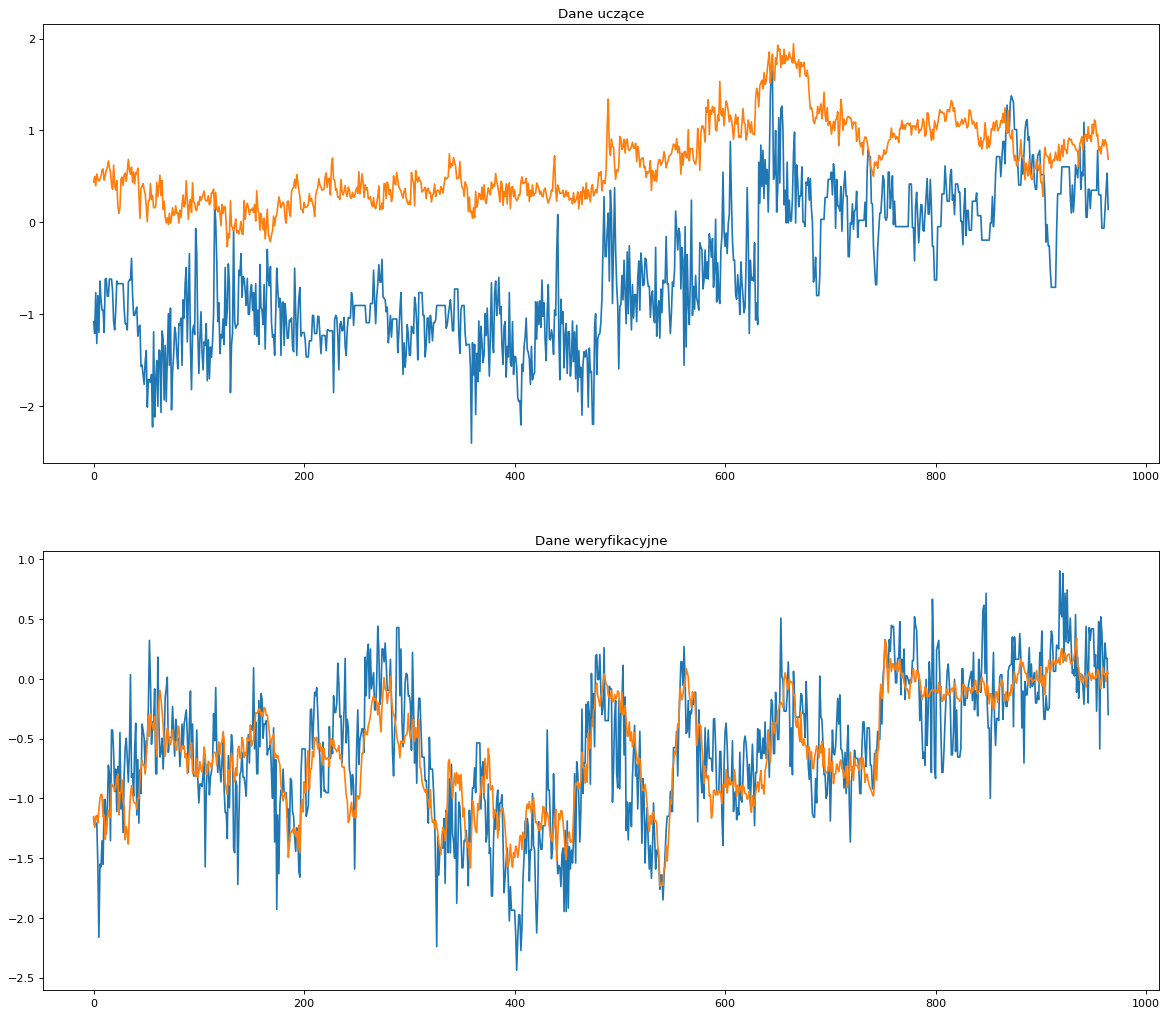

In [62]:
optimM = np.empty(shape=(3, len(inputs) + 1), dtype=np.int32)
for index, value in enumerate(result.x):
    row = index % 3; col = index // 3
    optimM[row, col] = int(value)
print(optimM)

u_learn, y_learn = prepareSignals(scaledDataFrames[0], inputsdp, outputdp)
u_verif, y_verif = prepareSignals(scaledDataFrames[2], inputsdp, outputdp)

maxDelay, maxOrder = findMaxDelayAndOrder(optimM)   
numberOfSamples = y_learn.shape[0]
output_learn_cut = y_learn[maxDelay : numberOfSamples - maxOrder]
output_verif_cut = y_verif[maxDelay : numberOfSamples - maxOrder]
A_learn = createModelMatrix(u_learn, optimM)
#
u_learn1, y_learn1 = prepareSignals(scaledDataFrames[1], inputsdp, outputdp)
u_verif1, y_verif1 = prepareSignals(scaledDataFrames[1], inputsdp, outputdp)
numberOfSamples = y_learn1.shape[0]
output_learn_cut1 = y_learn1[maxDelay : numberOfSamples - maxOrder]
output_verif_cut1 = y_verif1[maxDelay : numberOfSamples - maxOrder]
A_learn1 = createModelMatrix(u_learn1, optimM)
#
u_learn2, y_learn2 = prepareSignals(scaledDataFrames[2], inputsdp, outputdp)
u_verif2, y_verif2 = prepareSignals(scaledDataFrames[2], inputsdp, outputdp)
numberOfSamples = y_learn2.shape[0]
output_learn_cut2 = y_learn2[maxDelay : numberOfSamples - maxOrder]
output_verif_cut2 = y_verif2[maxDelay : numberOfSamples - maxOrder]
A_learn2 = createModelMatrix(u_learn2, optimM)
#

Al = np.vstack((A_learn1, A_learn1, A_learn2))
yl = np.vstack((output_learn_cut, output_learn_cut1, output_learn_cut2))
print(Al.shape)

model = linear_model.LinearRegression().fit(Al, yl)
score = evalModelScore(model, optimM, u_verif, y_verif)

print(model.coef_)

maxDelay, maxOrder = findMaxDelayAndOrder(optimM)
numberOfSamples = y_learn.shape[0]
output_learn_cut = y_learn[maxDelay : numberOfSamples - maxOrder]
output_verif_cut = y_verif[maxDelay : numberOfSamples - maxOrder]

# A_verif = createModelMatrix(u_verif, optimM)
A_learn = createModelMatrix(u_learn, optimM)
y_model_learn = model.predict(A_learn)
# y_model_verif = model.predict(A_verif)

data_idx = maxOrder+maxDelay+1
u_verif_wip = np.array(u_verif[0:data_idx],copy=True)
A_verif = createModelMatrix(u_verif_wip, optimM)
    
model_outputs = np.array([])
for i in range(data_idx, data_idx+len(output_learn_cut)):
    output_model_verif = model.predict(A_verif)
    model_outputs = np.append(model_outputs, output_model_verif)
    u_verif_wip = np.vstack((u_verif_wip, u_verif[data_idx:data_idx+1]))[1:]
    data_idx += 1
    u_verif_wip[-1][-1] = output_model_verif[-1]
    A_verif = createModelMatrix(u_verif_wip, optimM) 
        
verif_score = r2_score(output_verif_cut, model_outputs)
print(verif_score)

# plot data
fig, axs = plt.subplots(2,figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
axs[0].plot(output_learn_cut)
axs[0].plot(y_model_learn)
axs[0].set_title("Dane uczące")
axs[1].plot(output_verif_cut)
axs[1].plot(model_outputs)
axs[1].set_title("Dane weryfikacyjne")
plt.rcParams['figure.figsize'] = [15, 20]